In [2]:
import os
import re
import unicodedata
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import textacy.preprocessing as tprep
from datetime import datetime
from dotenv import load_dotenv
from transformers import BertTokenizer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder, PowerTransformer

In [3]:
load_dotenv()
data_dir = os.getenv("DATA_DIR")
raw_data_path = os.path.join(data_dir, "raw", "anime_data.csv")
raw_data = pd.read_csv(raw_data_path)

'id,' # Anime ID (integer)\
'title,' # Anime title (string)\
✅'synopsis,' # Anime synopsis (string or null)\
✅'mean,' # Mean score (float or null)\
✅'popularity,' # Popularity rank (integer or null)\
🛑'num_list_users,' # Number of users who have the anime in their list (integer)\
✅'num_scoring_users,' # Number of users who have scored the anime (integer)\
✅'nsfw,' # NSFW classification (white=sfw, gray=partially, black=nsfw) (string or null)\
✅'genres,' # Genres (array of objects)\
✅'studios,' # Studios (array of objects)\
✅'num_episodes,' # Number of episodes (integer)\
✅'average_episode_duration,' # Average duration of an episode (integer or null)\
✅'status,' # Airing status (string)\
✅'rating,' # Age rating (string or null) (g, pg, pg_13, r, r+, rx)\
✅'source,' # Source (string or null)\
✅'media_type,' # Media type (string)\
🛑'created_at,' # Date of creation (string <date-time>)\
🛑'updated_at,' # Date of last update (string <date-time>)\
✅'start_season,' # Start season (object or null)\
✅'start_date,' # Start date (string or null)\
✅'end_date,' # End date (string or null)\
'related_anime,' # Related anime (array of objects)\
'related_manga,' # Related manga (array of objects)\
'recommendations,' # Recommendations (array of objects)\
'statistics' # Statistics (object or null)

## Analyze Synopses

In [121]:
def clean_text(text):
    text = unicodedata.normalize('NFKC', text)  # Unicode normalization
    text = tprep.normalize.hyphenated_words(text)  # Normalize hyphenated words
    text = tprep.normalize.quotation_marks(text)  # Normalize quotation marks
    text = tprep.remove.accents(text)  # Remove accents
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags if any
    text = re.sub(r"\(.*source.*\)", "", text, flags=re.IGNORECASE)  # Remove source citations
    text = re.sub(r"\[.*MAL.*\]", "", text)  # Remove MAL citations
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    text = text.strip()  # Strip whitespace from the beginning and the end
    return text
raw_data.dropna(inplace=True)
raw_data['synopsis'] = raw_data['synopsis'].apply(clean_text)

In [123]:
raw_data['synopsis'].to_csv(os.path.join(data_dir, "interim", "synopsis.csv"), index=False, header=False)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
raw_data['tokenized_synopsis'] = raw_data['synopsis'].apply(lambda x: tokenizer(x, truncation=True, max_length=512, return_tensors='pt') if not pd.isna(x) else None)
raw_data['tokenized_synopsis_length'] = raw_data['tokenized_synopsis'].apply(lambda x: x['input_ids'].shape[1] if not pd.isna(x) else 0)

Check to see how many synopses will be truncated by the tokenizer.

In [ ]:
def safe_length(synopsis):
    if pd.isna(synopsis):
        return 0  # Return 0 for NaN values
    return len(synopsis)

raw_data['synopsis_length'] = raw_data['synopsis'].apply(safe_length)

synopsis_length = raw_data['synopsis_length']
sns.histplot(synopsis_length)
plt.axvline(synopsis_length.mean(), c='k', ls='-', lw=2.5)
plt.axvline(synopsis_length.median(), c='orange', ls='--', lw=2.5)
raw_data['synopsis_length'].describe()

In [ ]:
tokenized_length = raw_data['tokenized_synopsis_length']
sns.histplot(tokenized_length)
plt.axvline(tokenized_length.mean(), c='k', ls='-', lw=2.5)
plt.axvline(tokenized_length.median(), c='orange', ls='--', lw=2.5)
print(raw_data['tokenized_synopsis_length'].describe())
print('Number of synopses of max tokenized length:', raw_data[raw_data['tokenized_synopsis_length'] == 512]['id'].count())

## Analyze Numerical Features

In [4]:
def check_normal(column=None, data=None):
    if column is not None:
        data = raw_data[column].fillna(raw_data[column].mean())
    #res = stats.shapiro(data)
    res2 = stats.normaltest(data)
    if res2.pvalue > 0.05:
        print("Normal")
    else:
        print("Not Normal")

def plot(data, ax):
    sns.histplot(data, ax=ax, log_scale=False)
    #plt.axvline(data.mean(), c='k', ls='-', lw=1.5)
    #plt.axvline(data.median(), c='orange', ls='--', lw=1.5)
    #plt.xlim(0, data.quantile(.95))
    #iqr = stats.iqr(data)
    #lower_bound = data.quantile(.25) - 1.5 * iqr
    #upper_bound = data.quantile(.75) + 1.5 * iqr
    #outliers = data[(data < lower_bound) | (data > upper_bound)]
    #print(f'Number of data points: {data.count()} Number of outliers: {outliers.count()}, {100*outliers.count()/data.count():.2f}%')
    stats_df = pd.DataFrame(data).describe()
    # Transpose for easier key-value access
    stats_transposed = stats_df.T
    stats_text = "\n".join([f"{stat}: {value:.2f}" for stat, value in stats_transposed.iloc[0].items()])
    ax.legend([stats_text], title='Descriptive Stats', loc='upper right', fontsize='small')
    

def analyze(column, type, fill='mean', post_st=False, clip=False):
    if fill == 'mean':
        data = raw_data[column].fillna(raw_data[column].mean())
    elif fill == 'mode':
        data = raw_data[column].fillna(raw_data[column].mode())
    elif fill == 'median':
        data = raw_data[column].fillna(raw_data[column].median())
    else:
        data = raw_data.dropna()
    f, axes = plt.subplots(1, 2, figsize=(12, 6))
    if clip:
        q = raw_data[column].quantile(.95)
        data = data[data <= q]
    data = pd.DataFrame(data=data)
    plot(data, axes[0])

    if type == 'standard':
        data = StandardScaler().fit_transform(data)
    elif type == 'robust':
        data = RobustScaler().fit_transform(data)
    elif type == 'power':
        data = PowerTransformer().fit_transform(data)
    elif type == 'quantile':
        data = QuantileTransformer().fit_transform(data)
    elif type == 'log':
        data = data.apply(np.log1p)
    else:
        raise ValueError("Invalid type")
    
    if post_st:
        data = StandardScaler().fit_transform(data)

    plot(data, axes[1])

    f.suptitle(f'{column} - {type}', fontsize=16)
    plt.show()

### mean

Not Normal


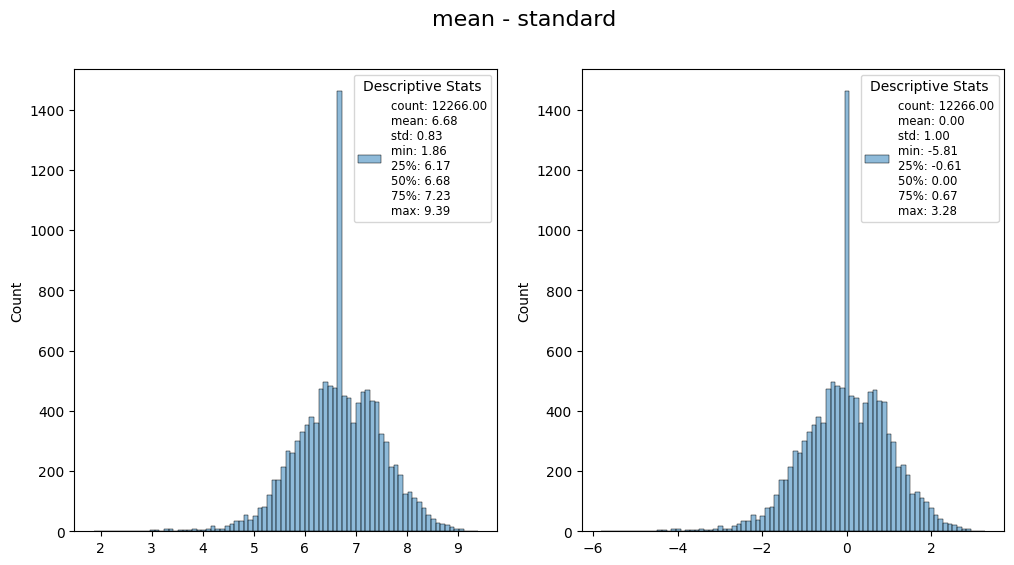

In [95]:
check_normal('mean')
analyze('mean', 'standard')

### num_list_users

Not Normal


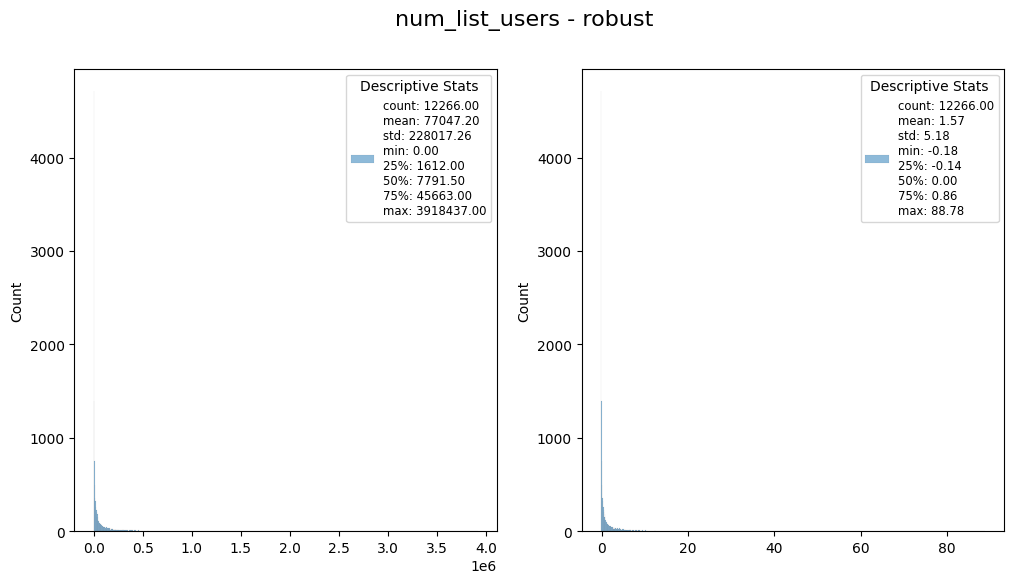

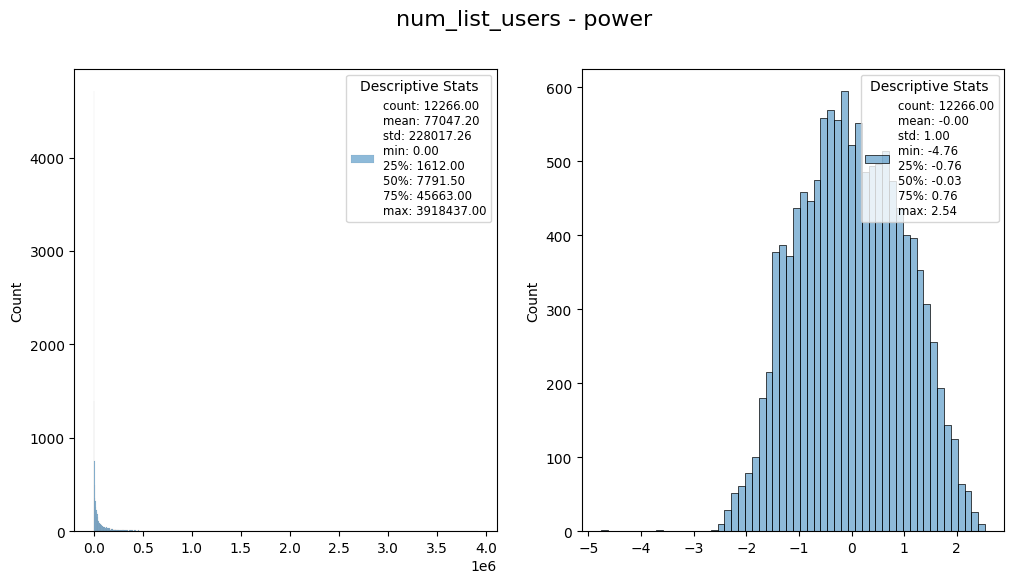

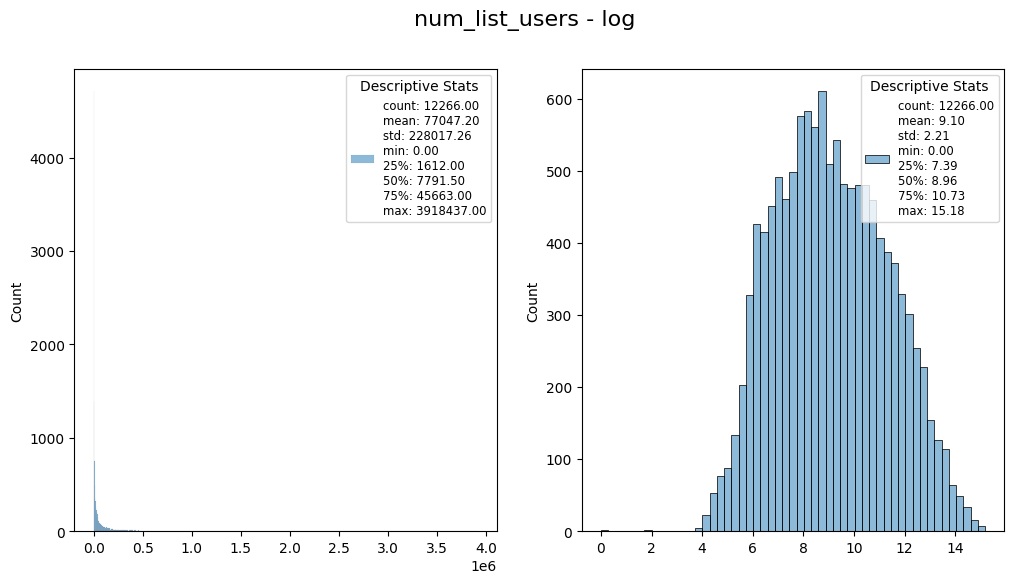

In [99]:
# num_list_users does not match statistics.num_list_users ==> use statistics.num_list_users and drop num_list_users
check_normal('num_list_users')
analyze('num_list_users', 'robust')
analyze('num_list_users', 'power')
analyze('num_list_users', 'log')

### popularity

Not Normal


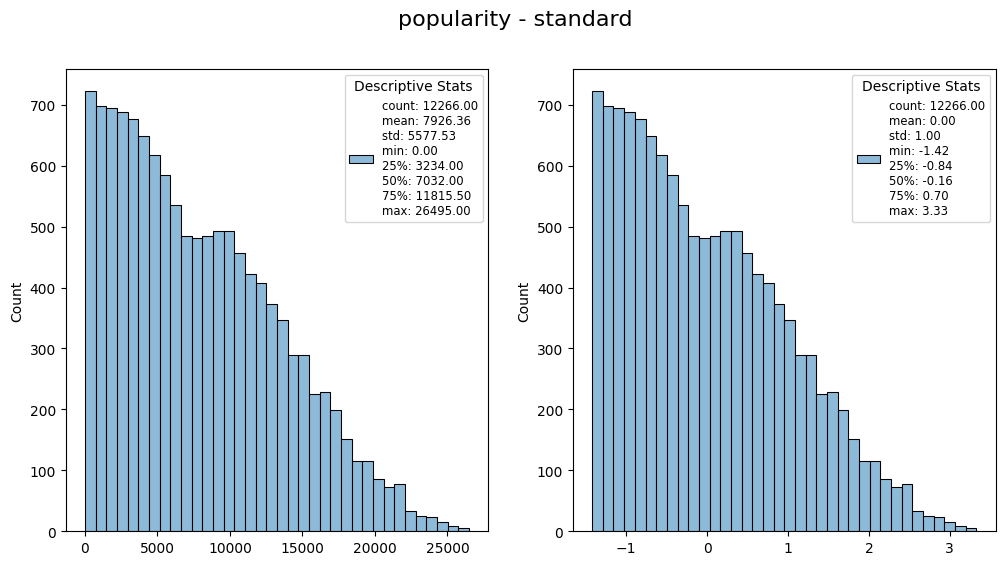

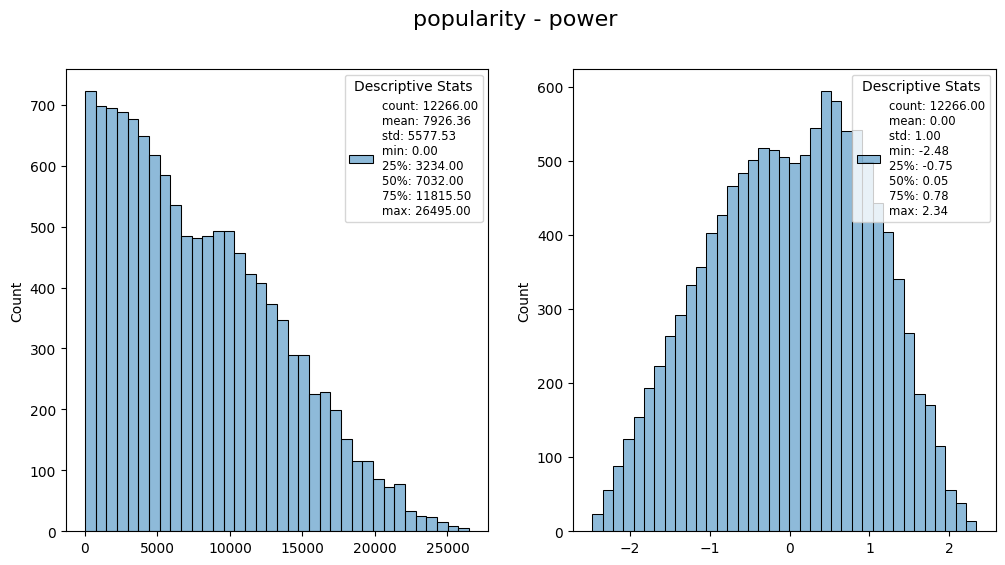

In [101]:
check_normal('popularity')
analyze('popularity', 'standard')
analyze('popularity', 'power')

### num_scoring_users

Not Normal


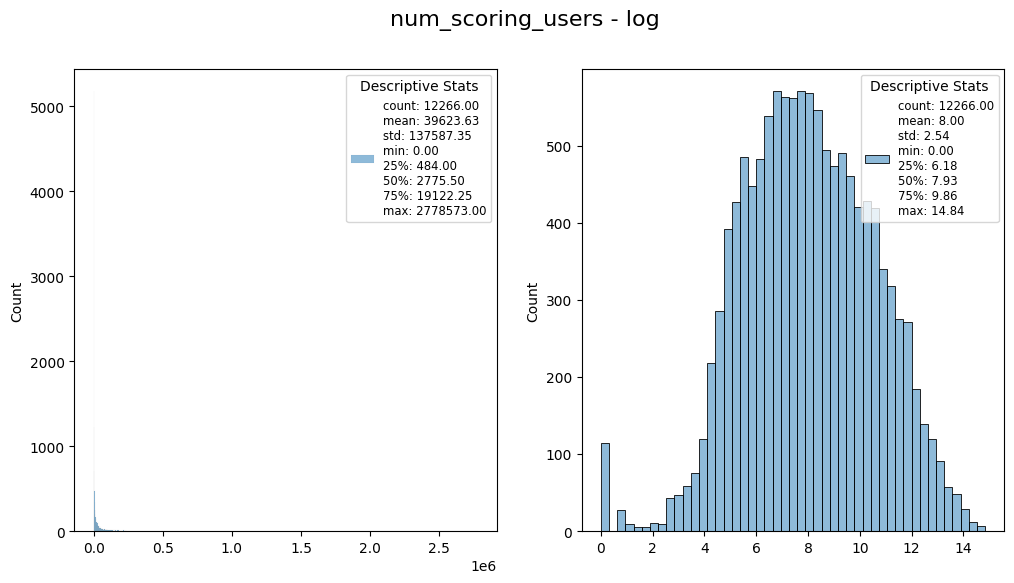

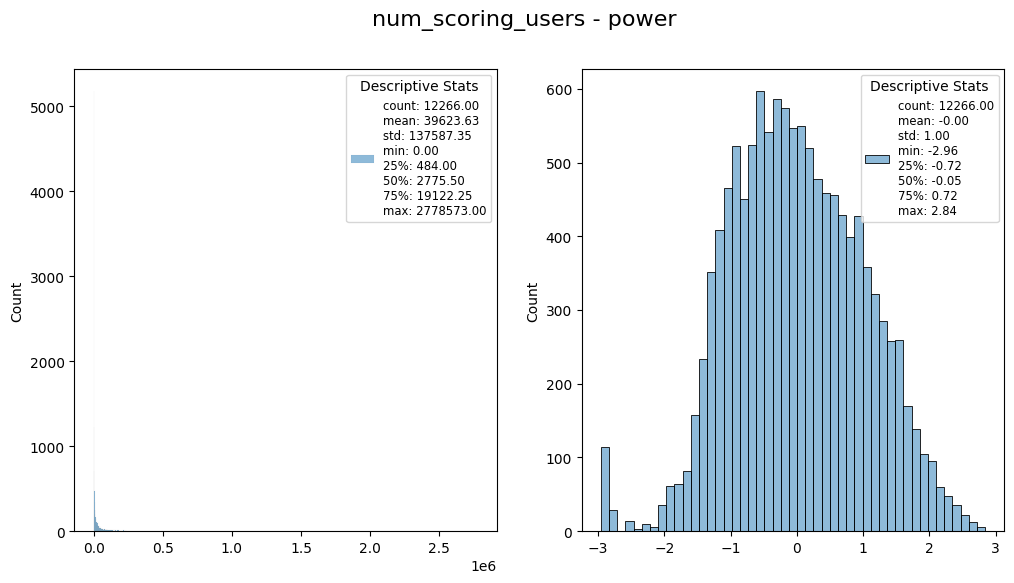

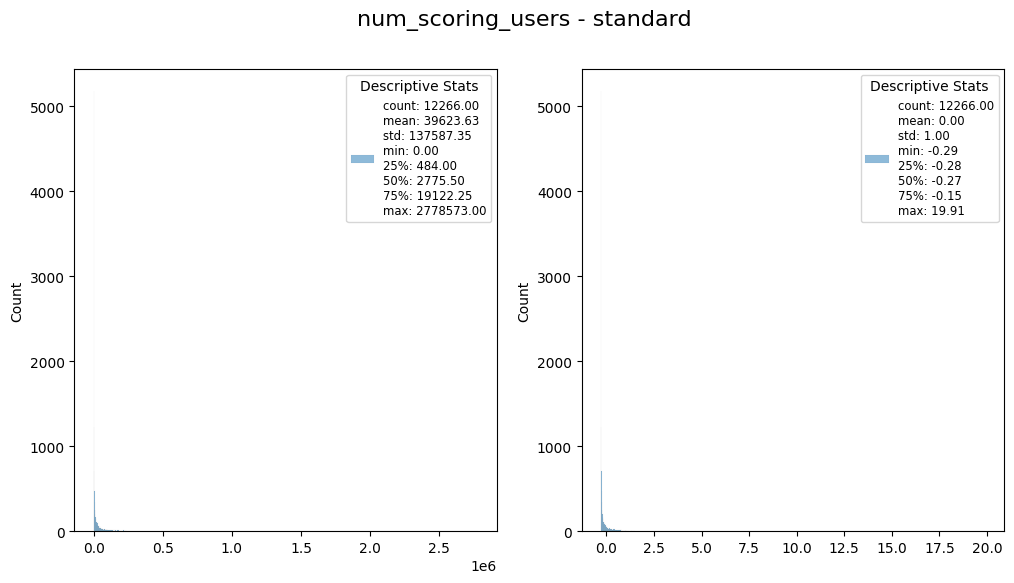

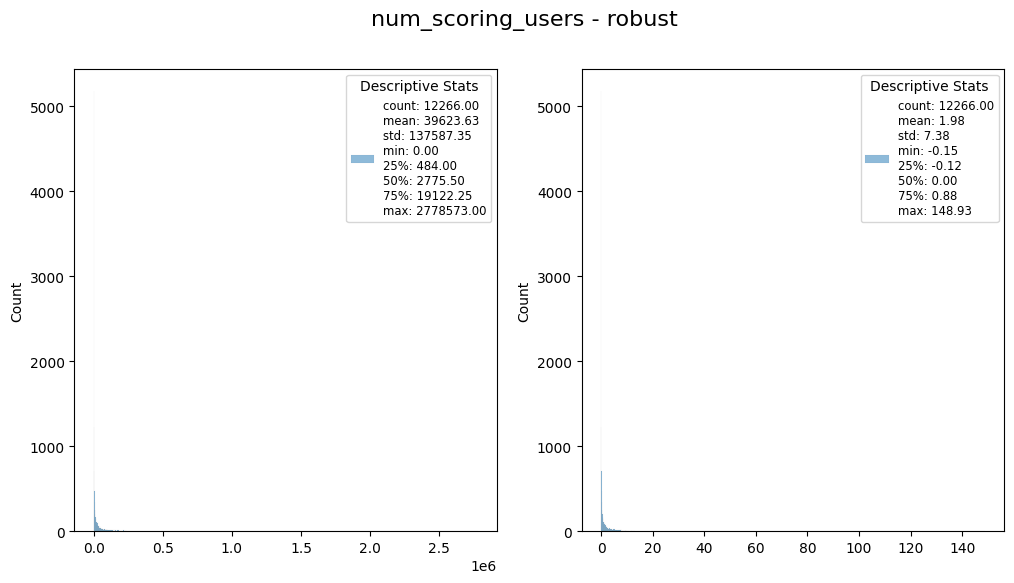

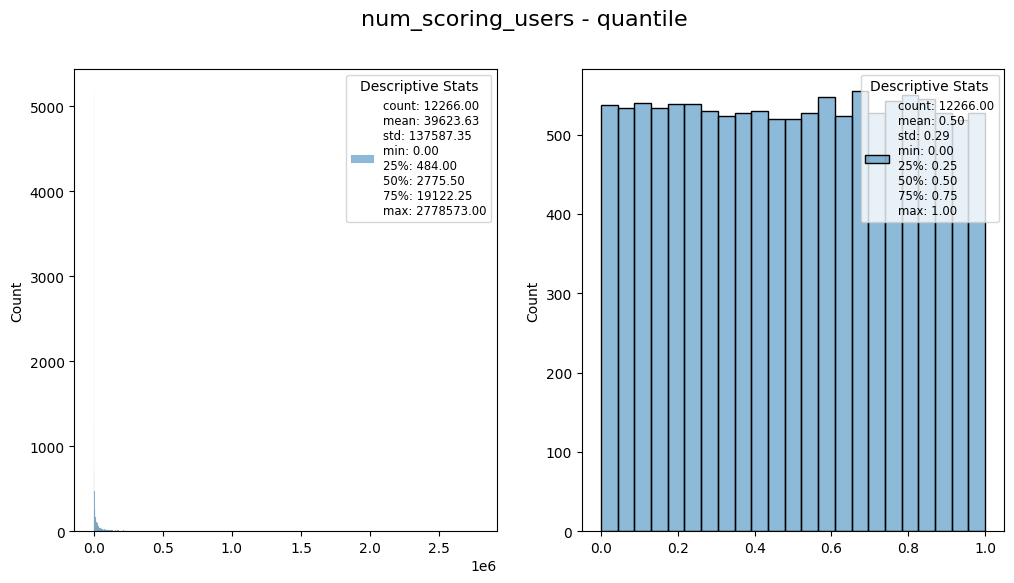

In [102]:
check_normal('num_scoring_users')
analyze('num_scoring_users', 'log')
analyze('num_scoring_users', 'power')
analyze('num_scoring_users', 'standard')
analyze('num_scoring_users', 'robust')
analyze('num_scoring_users', 'quantile')

### num_episodes

Not Normal


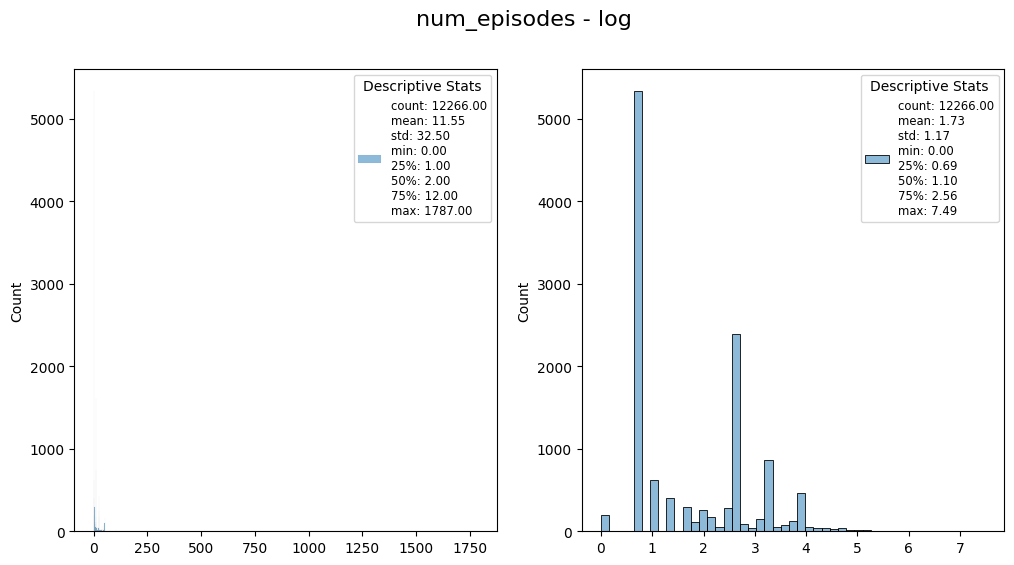

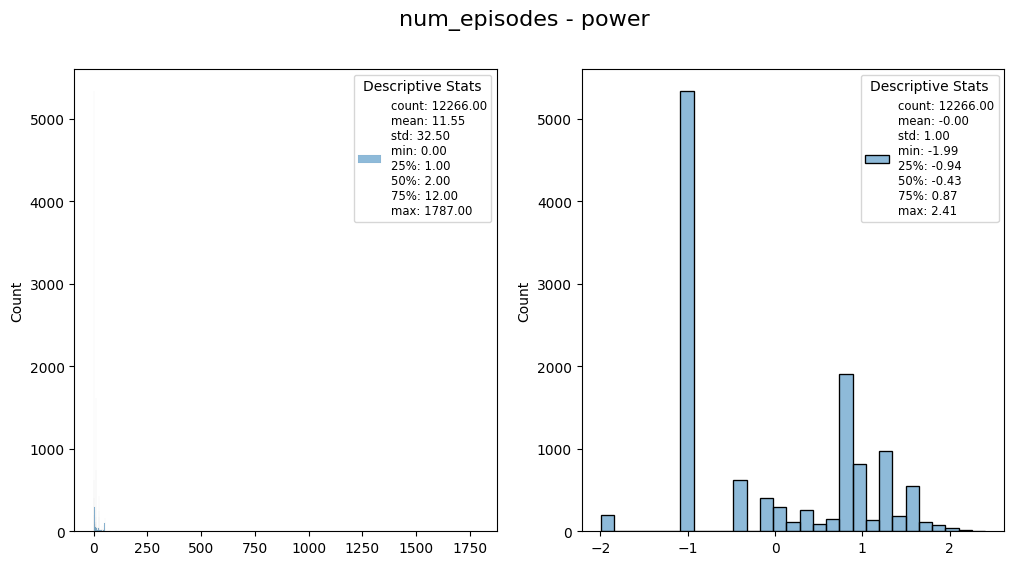

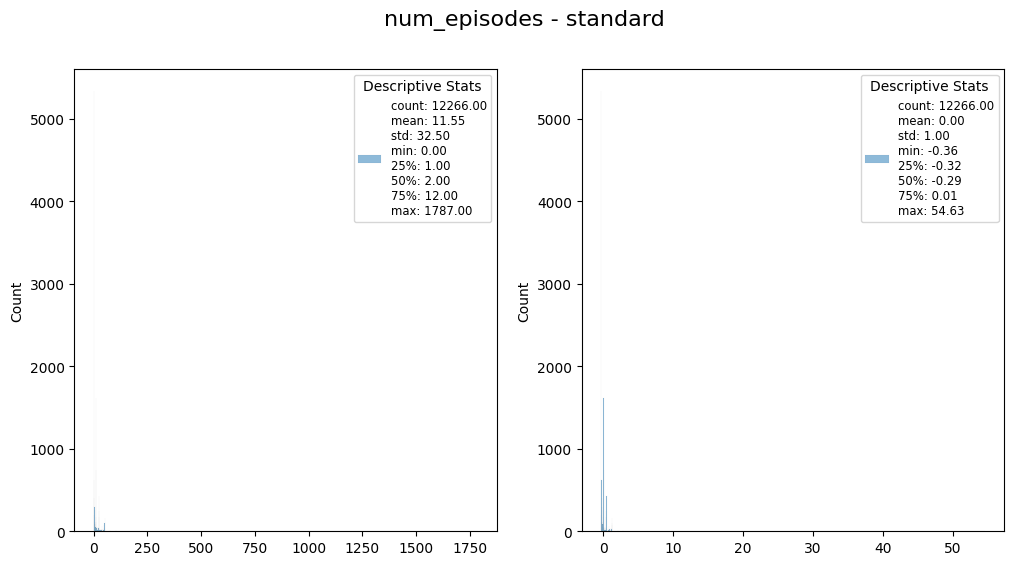

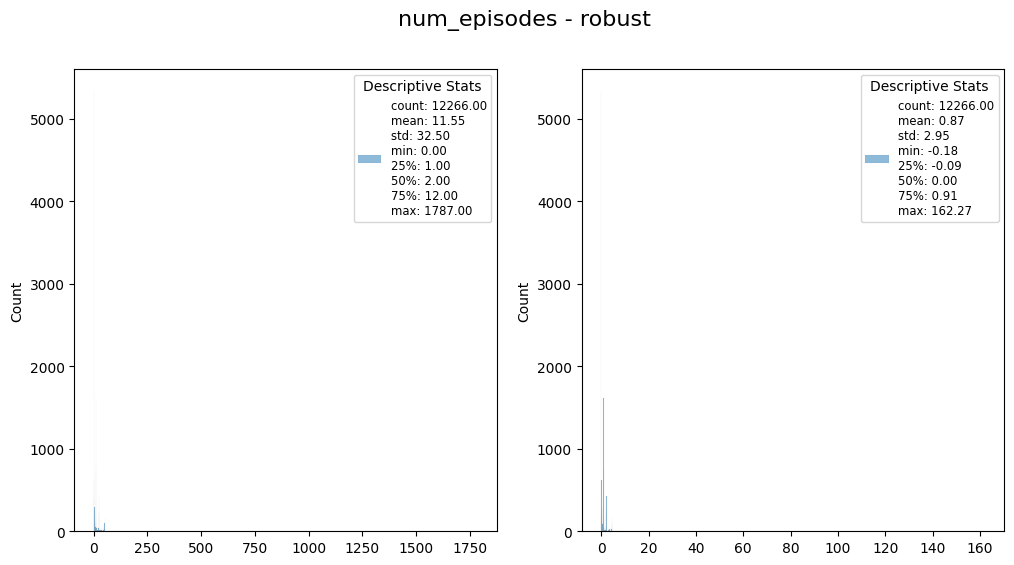

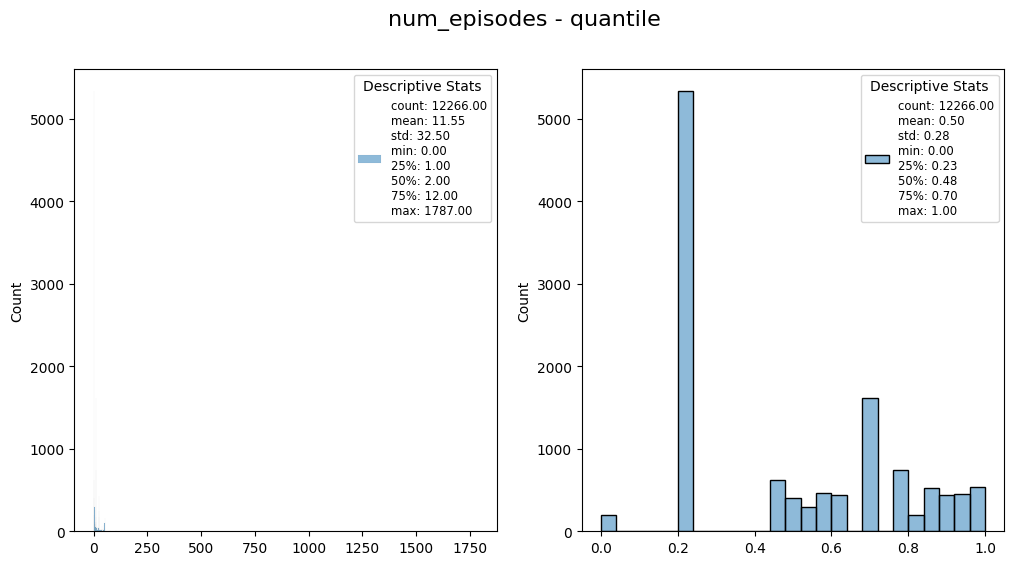

In [103]:
check_normal('num_episodes')
analyze('num_episodes', 'log')
analyze('num_episodes', 'power')
analyze('num_episodes', 'standard')
analyze('num_episodes', 'robust')
analyze('num_episodes', 'quantile')

### average_episode_duration

Not Normal


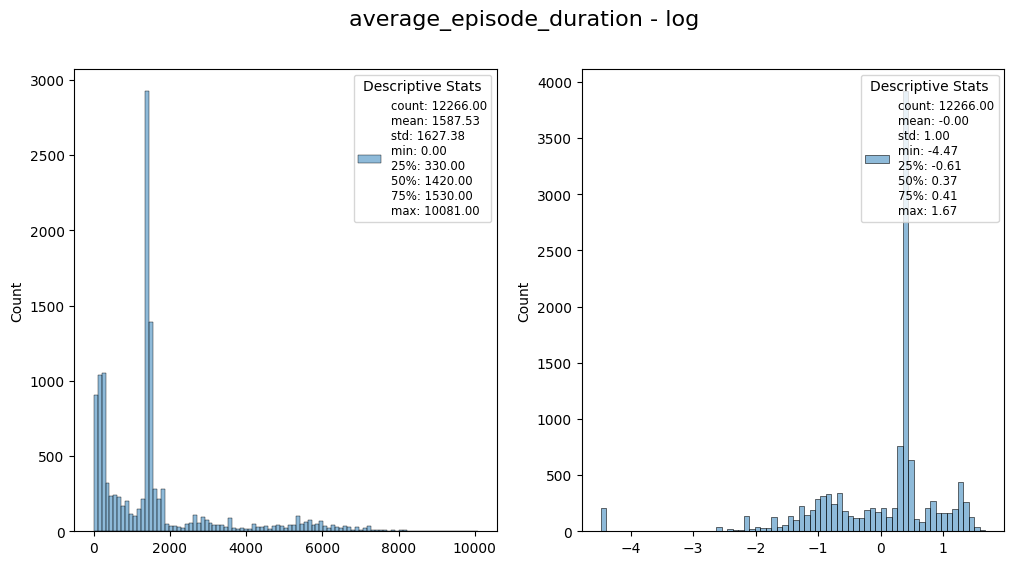

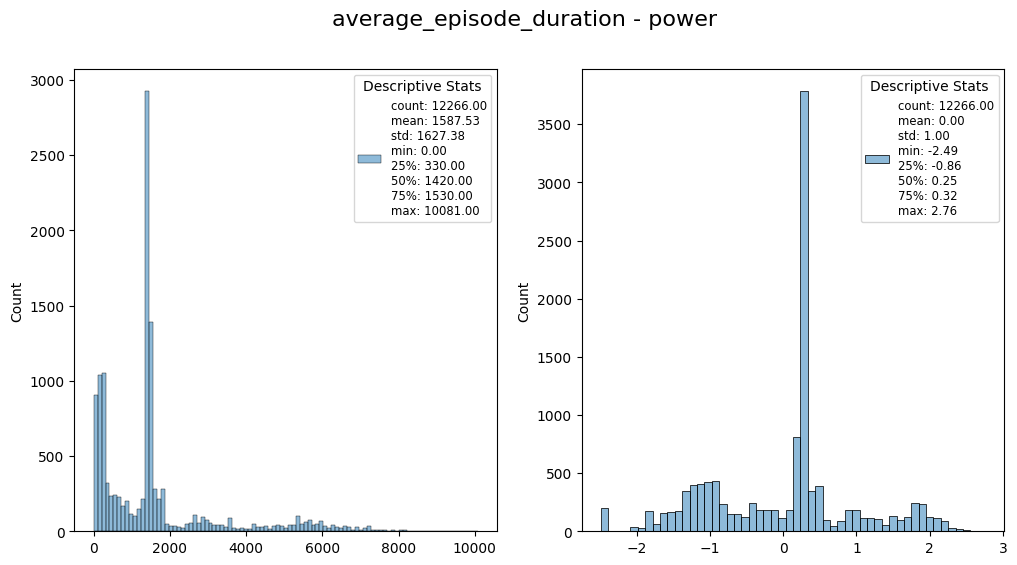

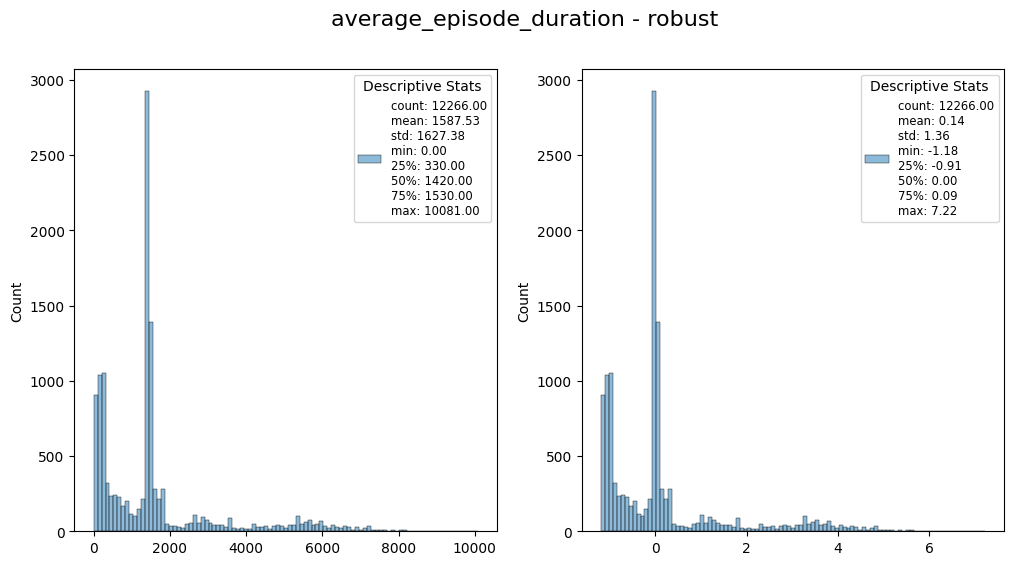

In [105]:
check_normal('average_episode_duration')
analyze('average_episode_duration', 'log', post_st=True)
analyze('average_episode_duration', 'power')
analyze('average_episode_duration', 'robust')

## Analyze Statistics

In [5]:
statistics = raw_data[['num_list_users', 'num_scoring_users', 'statistics.status.watching', 'statistics.status.completed', 'statistics.status.on_hold', 'statistics.status.dropped',
       'statistics.status.plan_to_watch', 'statistics.num_list_users']]
raw_data['sum'] = statistics['statistics.status.watching'] + statistics['statistics.status.completed'] + statistics['statistics.status.on_hold'] + statistics['statistics.status.dropped'] + statistics['statistics.status.plan_to_watch']

Not Normal


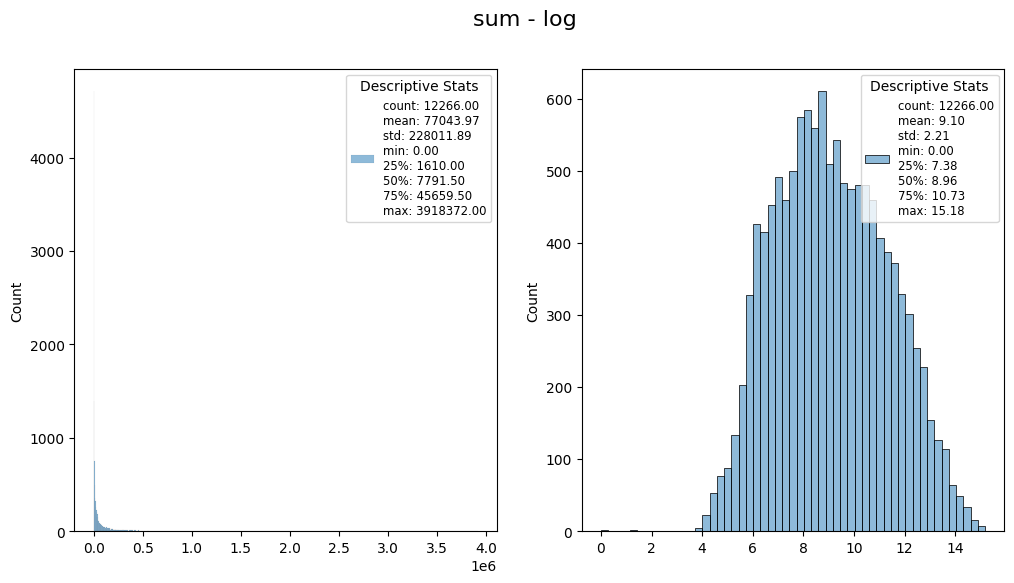

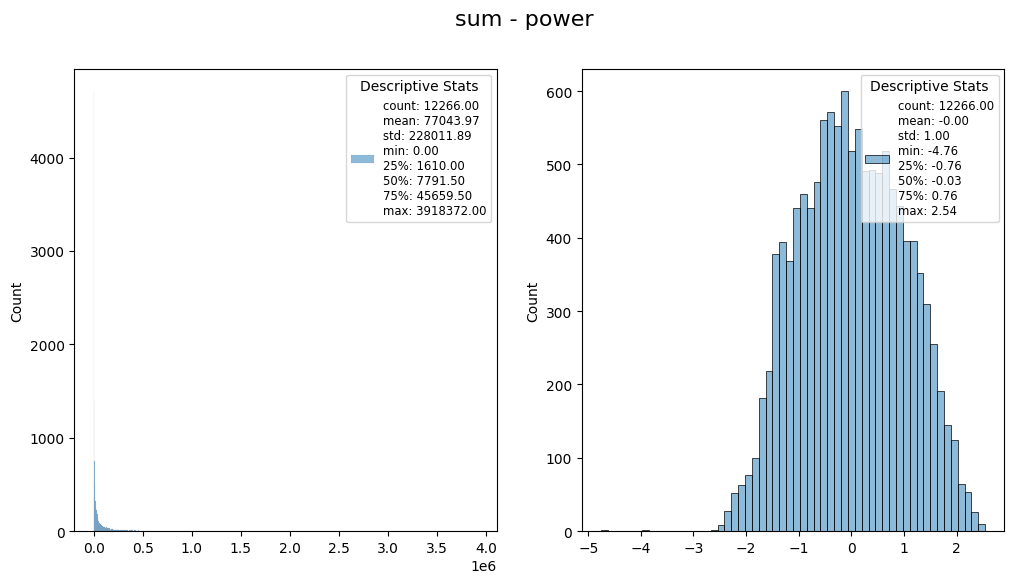

<Axes: ylabel='Count'>

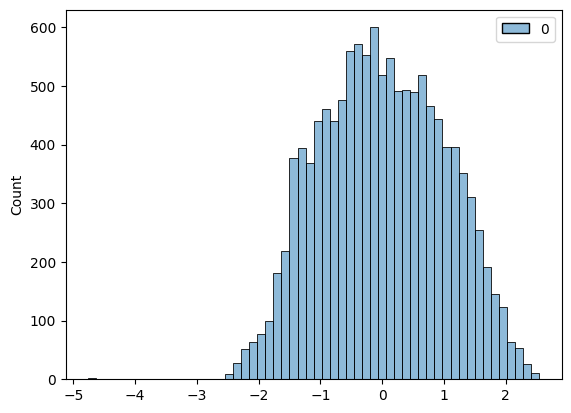

In [6]:
check_normal(data=raw_data['sum'])
analyze('sum', 'log')
analyze('sum', 'power')

Not Normal


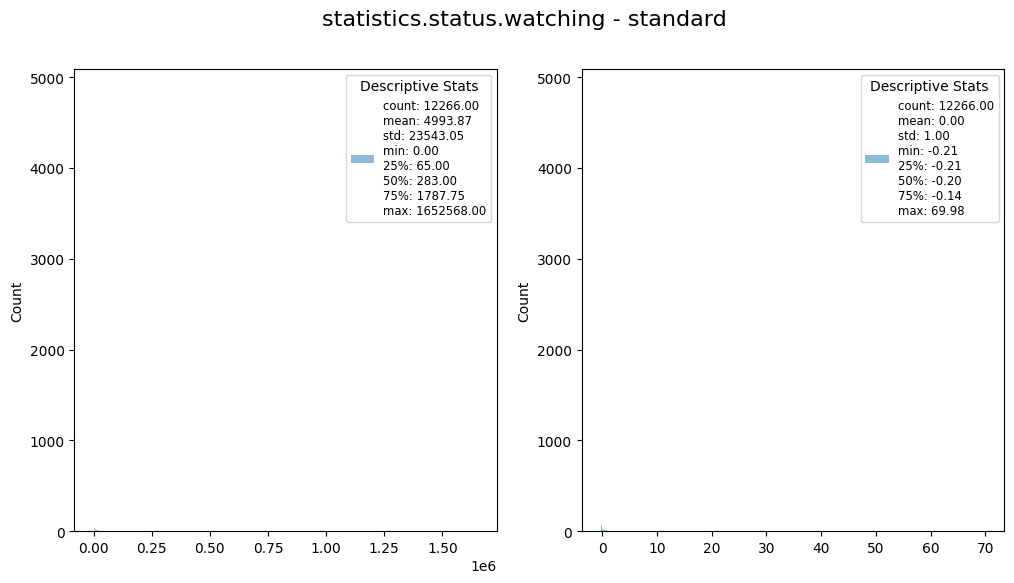

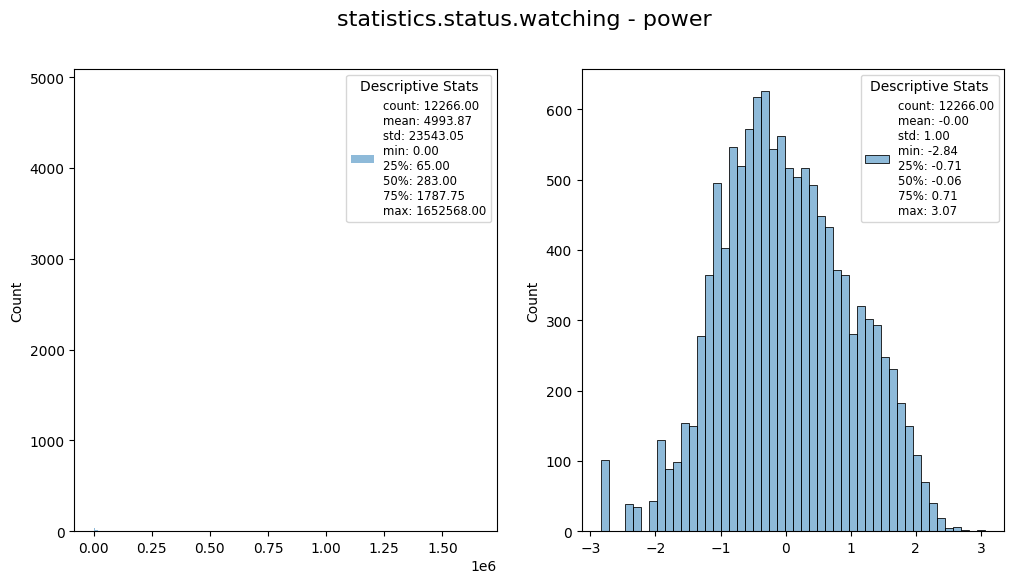

In [110]:
check_normal('statistics.status.watching')
analyze('statistics.status.watching', 'standard')
analyze('statistics.status.watching', 'power')

Not Normal


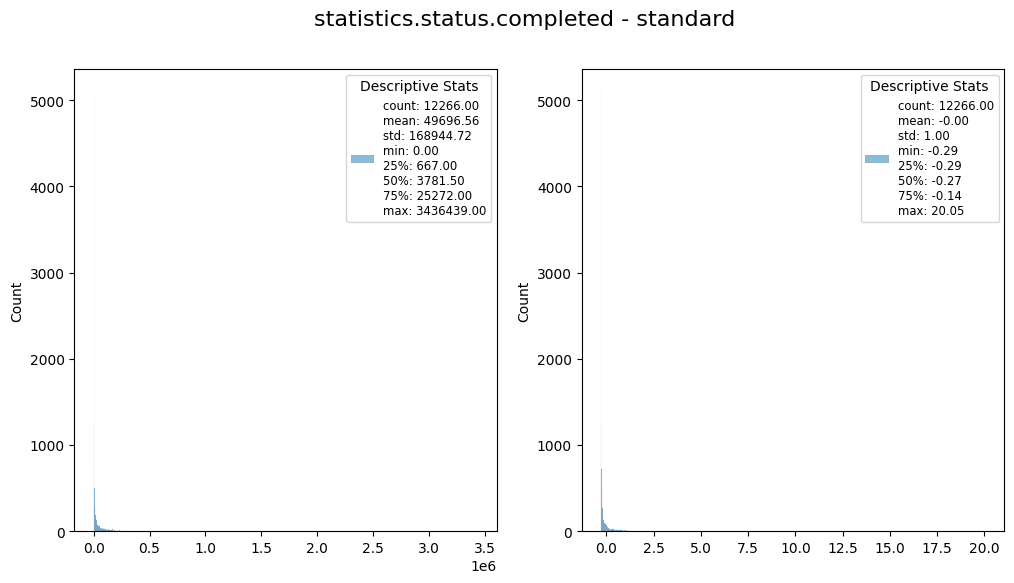

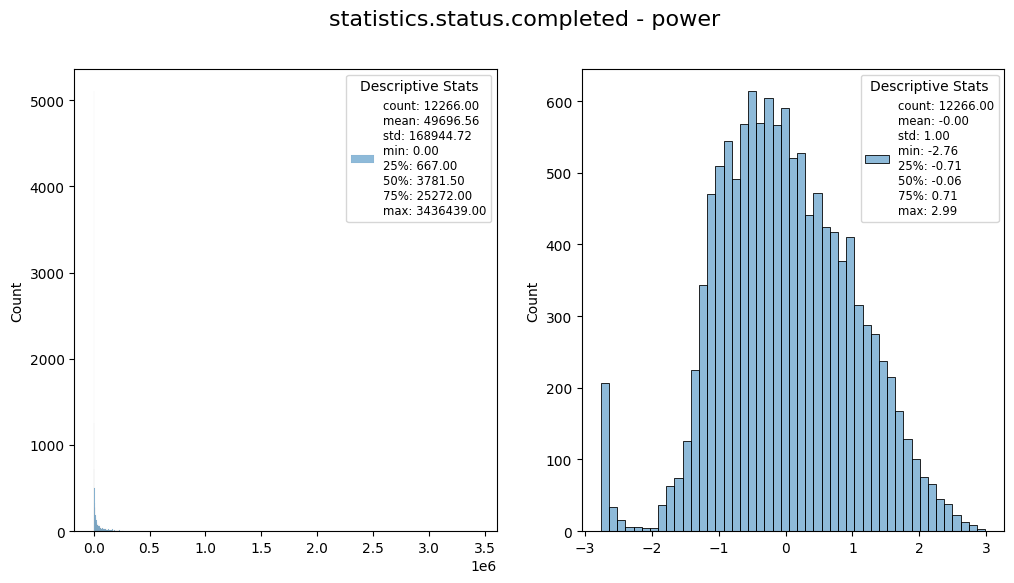

In [111]:
check_normal('statistics.status.completed')
analyze('statistics.status.completed', 'standard')
analyze('statistics.status.completed', 'power')

Not Normal


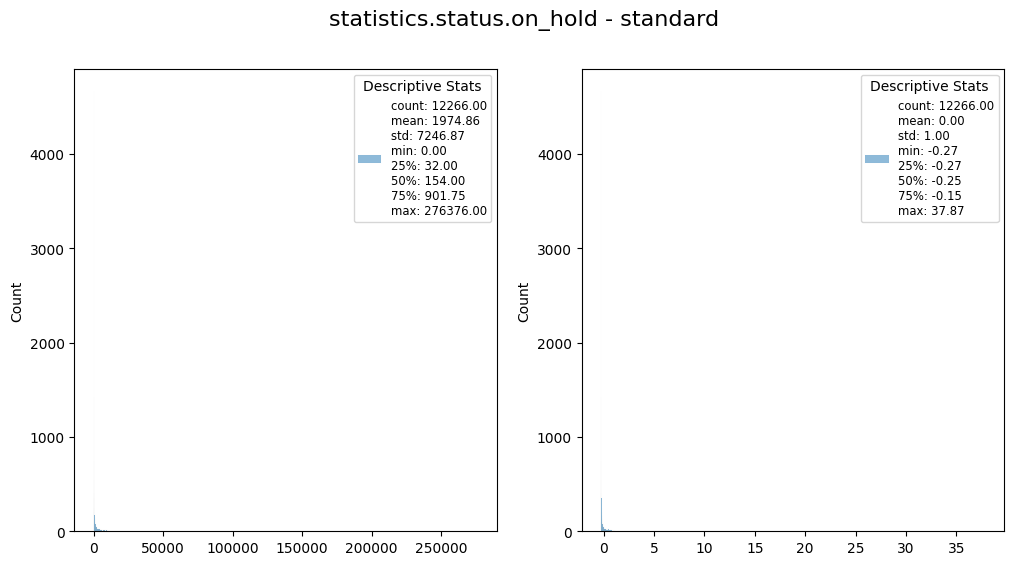

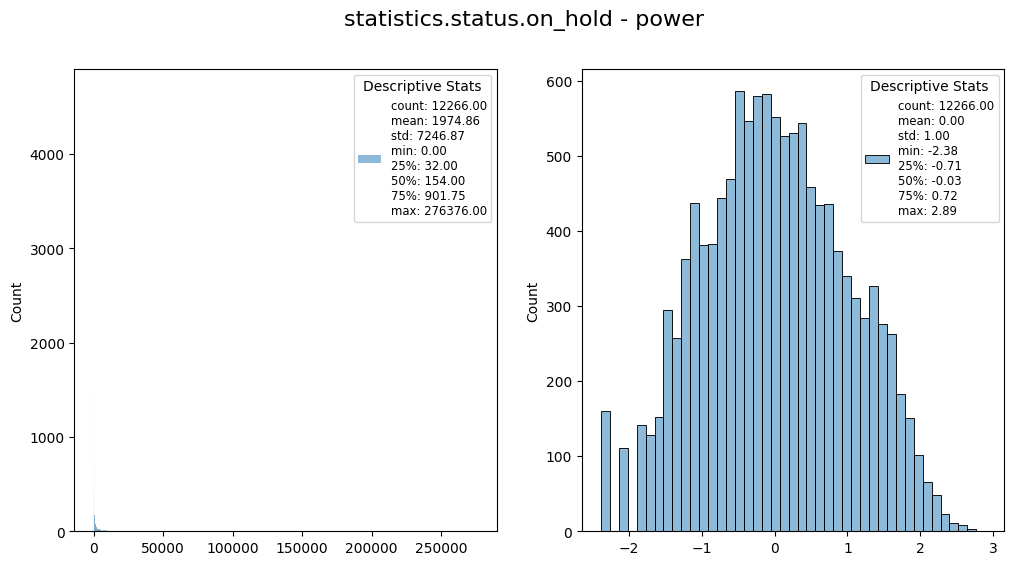

In [112]:
check_normal('statistics.status.on_hold')
analyze('statistics.status.on_hold', 'standard')
analyze('statistics.status.on_hold', 'power')

Not Normal


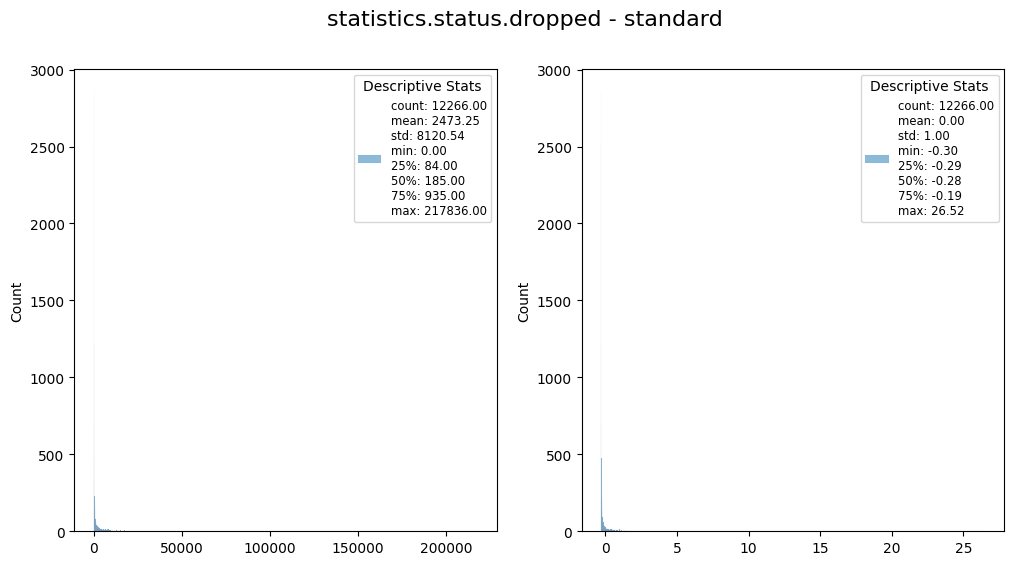

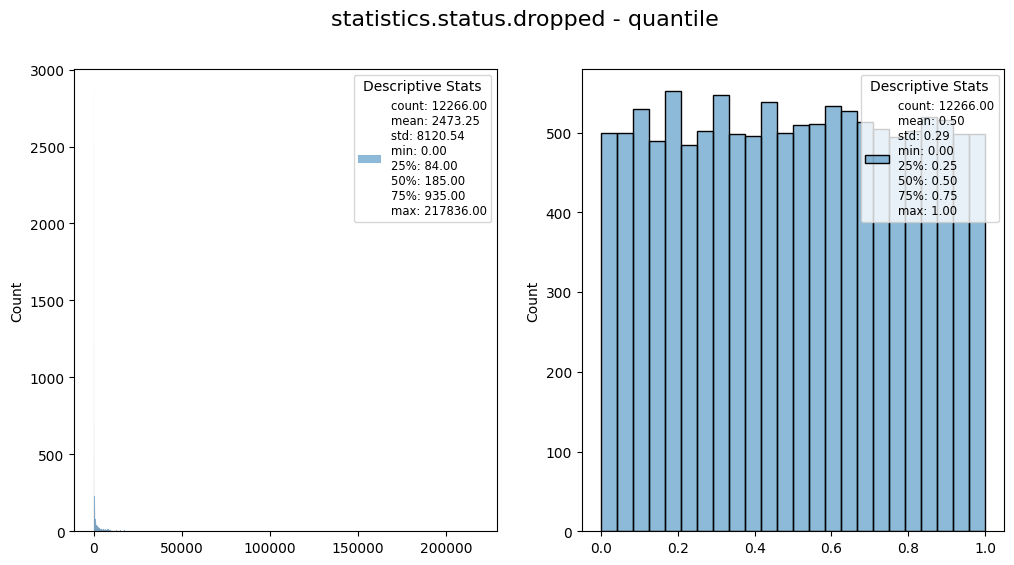

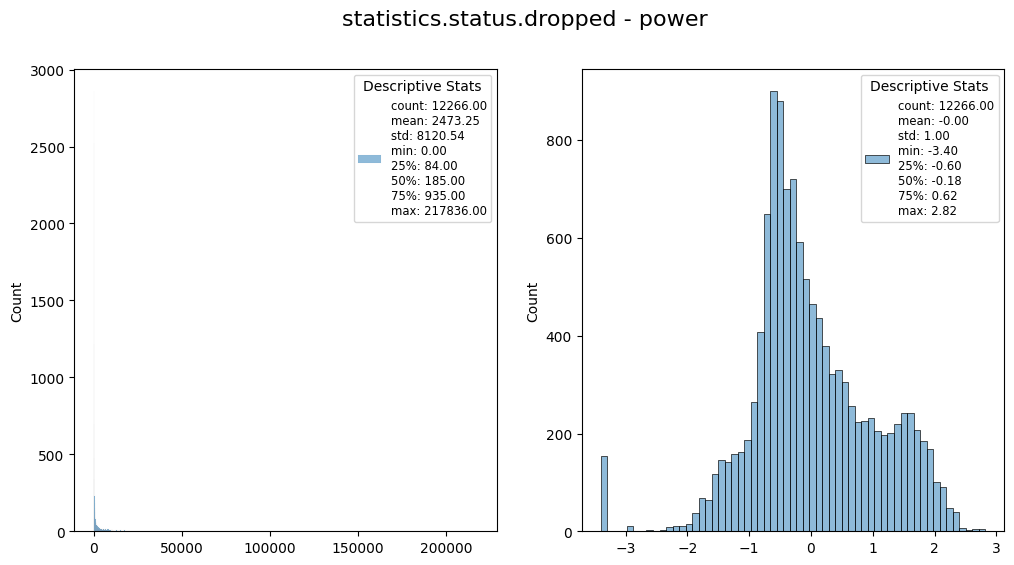

In [114]:
check_normal('statistics.status.dropped')
analyze('statistics.status.dropped', 'standard')
analyze('statistics.status.dropped', 'quantile')
analyze('statistics.status.dropped', 'power')

Not Normal


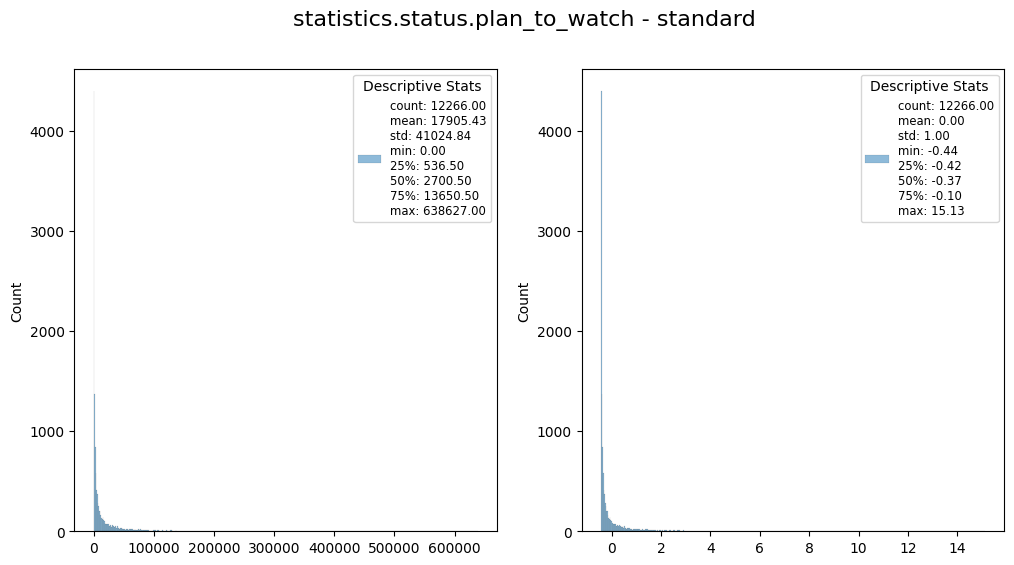

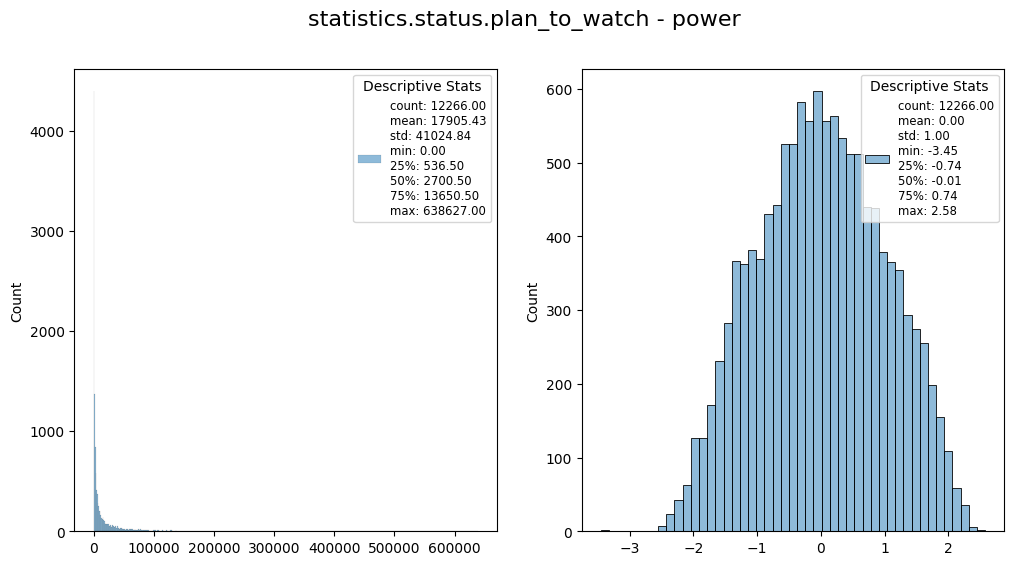

In [115]:
check_normal('statistics.status.plan_to_watch')
analyze('statistics.status.plan_to_watch', 'standard')
analyze('statistics.status.plan_to_watch', 'power')

## Analyze Date Information

In [4]:
# check what status animes are in where the start date is missing
raw_data[raw_data['start_date'].isna()]['status'].unique()

array(['not_yet_aired', 'finished_airing'], dtype=object)

In [44]:
def safe_date_convert(date) -> datetime.date:
    if pd.isna(date):
        return None
    if type(date) is float:
        return datetime.strptime(str(int(date)), '%Y').date()
    if type(date) is str:
        if re.compile("\d{4}-\d{2}-\d{2}").match(date):
            return datetime.strptime(date, '%Y-%m-%d').date()
        elif re.compile("\d{4}-\d{2}").search(date):
            return datetime.strptime(date, '%Y-%m').date()
        else:
            return datetime.strptime(date, '%Y').date()
    raise ValueError(f"Invalid date format: {date}, {type(date)}")

test = raw_data[['status', 'start_date', 'end_date', 'start_season.year', 'start_season.season']].dropna()
test['start_season.year'].apply(safe_date_convert)

0        2023-01-01
1        2009-01-01
2        2011-01-01
3        2015-01-01
4        2019-01-01
            ...    
12261    2022-01-01
12262    2022-01-01
12263    2022-01-01
12264    2022-01-01
12265    2022-01-01
Name: start_season.year, Length: 11628, dtype: object

### Test Encoding Start Season as a Cyclical Feature

In [40]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

# Encode the 'start_season.season' column using LabelEncoder
encoder = LabelEncoder()

# Create a new DataFrame to store the encoded labels and cyclical features
encoded_data = raw_data.dropna().copy()
encoded_labels = encoder.fit_transform(encoded_data['start_season.season'])
encoded_data['encoded_season'] = encoded_labels

# Apply the cyclical_encode function to create sine and cosine features
encoded_data = cyclical_encode(encoded_data, 'encoded_season', max_val=len(encoder.classes_))

# Print the encoded and transformed data
print(encoded_data[['start_season.season', 'encoded_season', 'encoded_season_sin', 'encoded_season_cos']])


      start_season.season  encoded_season  encoded_season_sin  \
0                    fall               0        0.000000e+00   
1                  spring               1        1.000000e+00   
2                  spring               1        1.000000e+00   
3                  spring               1        1.000000e+00   
4                  spring               1        1.000000e+00   
...                   ...             ...                 ...   
12261              spring               1        1.000000e+00   
12262              spring               1        1.000000e+00   
12263              summer               2        1.224647e-16   
12264                fall               0        0.000000e+00   
12265                fall               0        0.000000e+00   

       encoded_season_cos  
0            1.000000e+00  
1            6.123234e-17  
2            6.123234e-17  
3            6.123234e-17  
4            6.123234e-17  
...                   ...  
12261        6.123234e-

In [12]:
encoded_data.drop_duplicates(subset=['start_season.season'])[['start_season.season', 'encoded_season_sin', 'encoded_season_cos']]

,start_season.season,encoded_season_sin,encoded_season_cos
0,fall,0.000000e+00,1.000000e+00
1,spring,1.000000e+00,6.123234e-17
5,winter,-1.000000e+00,-1.836970e-16
16,summer,1.224647e-16,-1.000000e+00


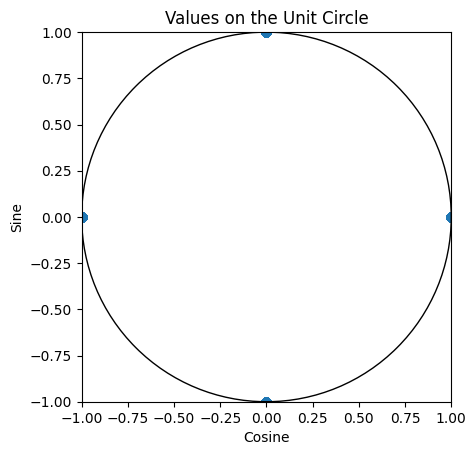

In [13]:
# Get the values from the columns
sin_values = encoded_data['encoded_season_sin']
cos_values = encoded_data['encoded_season_cos']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the values on the unit circle
ax.scatter(cos_values, sin_values)

# Set the aspect ratio to equal
ax.set_aspect('equal')

# Set the limits of the plot
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Add a unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_artist(circle)

# Add labels and title
ax.set_xlabel('Cosine')
ax.set_ylabel('Sine')
ax.set_title('Values on the Unit Circle')

# Show the plot
plt.show()


### Using Start and End Date to Calculate Duration

In [45]:
def time_diff(start_date, end_date):
    if pd.isna(start_date) or pd.isna(end_date):
        return None
    if start_date <= end_date:
        return (end_date - start_date).days
    else:
        return (start_date - end_date).days

converted = test
converted['start_date'] = converted['start_date'].apply(safe_date_convert)
converted['end_date'] = converted['end_date'].apply(safe_date_convert)
# calculate time difference
raw_data['time_diff'] = converted.apply(lambda x: time_diff(x['start_date'], x['end_date']), axis=1)

Not Normal


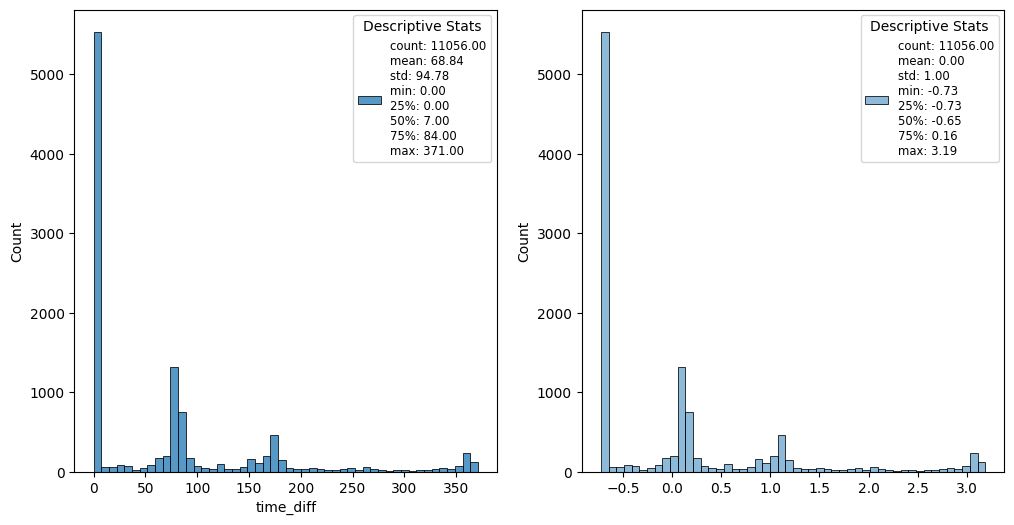

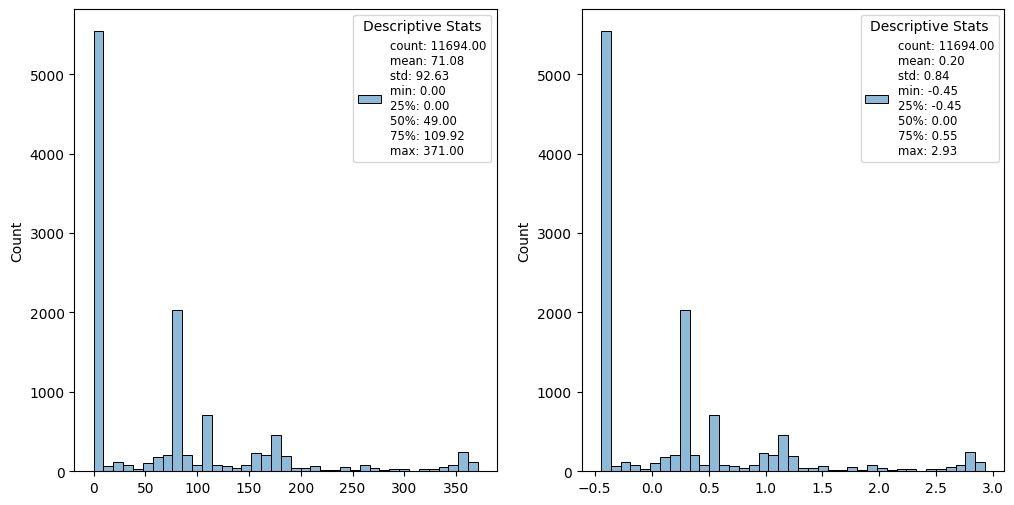

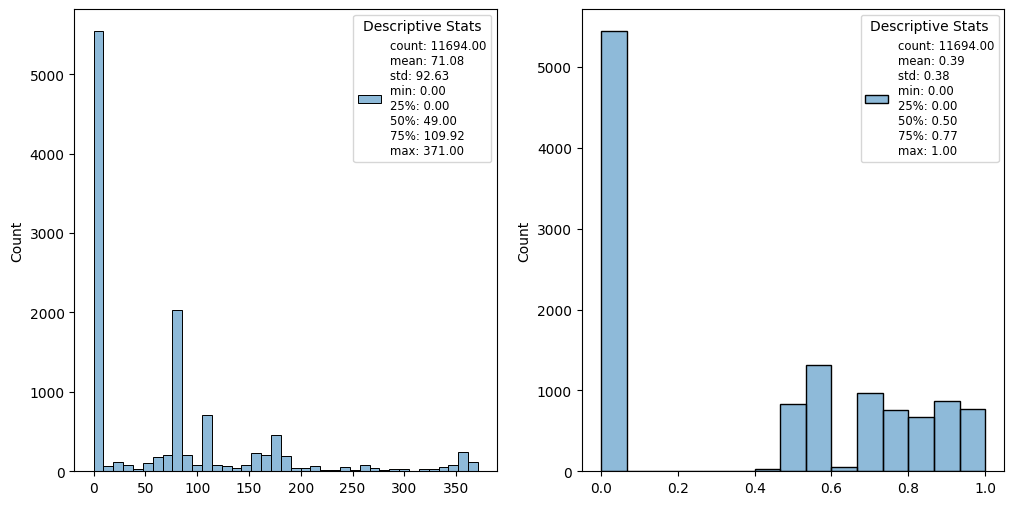

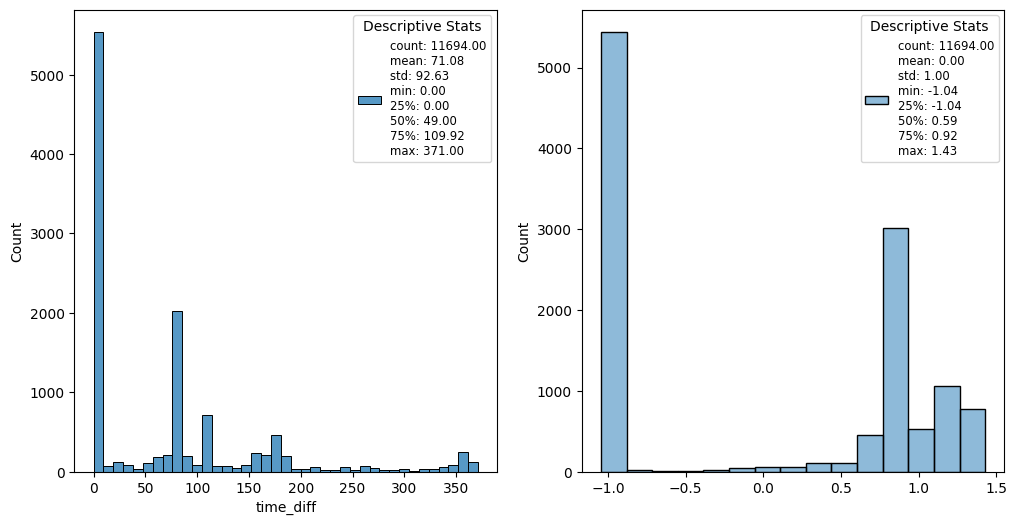

In [58]:
check_normal(data=raw_data['time_diff'])
analyze('time_diff', 'standard')
analyze('time_diff', 'robust')
analyze('time_diff', 'quantile')
analyze('time_diff', 'log')

In [63]:
# check duration of animes where full date information is available
date_data = raw_data[raw_data['start_date'].notna() & raw_data['end_date'].notna()]
date_data = date_data[date_data['start_date'].str.contains('-.*-') & date_data['end_date'].str.contains('-.*-')]
date_data['start_date'] = pd.to_datetime(date_data['start_date'], yearfirst=True)
date_data['end_date'] = pd.to_datetime(date_data['end_date'], yearfirst=True)
date_data['duration'] = date_data['end_date'].dt.date - date_data['start_date'].dt.date
date_data['duration'] = date_data['duration'].apply(lambda x: x.days)

In [64]:
d1 = datetime.strptime('2021-03', '%Y-%m').date()
d2 = datetime.strptime('2021-04', '%Y-%m').date()
print((d2 - d1).days)

31


In [70]:
# check for negative durations
date_data.loc[(date_data['duration'] < 0), ['start_date', 'end_date']]

,start_date,end_date
9802,2009-12-14,2009-08-26
